# Atmospheric pressure correction

This notebook uses example data to generate an atmospheric correction file.
Before using the notebook, create the -raw.cdf of the instrument data. 

In [1]:
from __future__ import division, print_function
import stglib
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd
import netCDF4

metdir = '/Users/nrrandall/NRR/DUNEX/NOAA/'
basedir = '/Users/nrrandall/NRR/DUNEX/1140/rbr208010/'

### Create raw .cdf file using glob_att and config files

In [2]:
run C:\Users\nrrandall\git\stglib\scripts\runrskrsk2cdf.py C:\Users\nrrandall\NRR\DUNEX\1140\rbr208010\glob_att1140.txt C:\Users\nrrandall\NRR\DUNEX\1140\rbr208010\solo3d1140_config.yaml

Loading from sqlite file 208010_20211009_0738.rsk; this may take a while for large datasets
Done fetching pressure data
Writing to raw netCDF
Done


### Generate atmospheric .nc file

Removes UTC from .csv file, converts pressure to decibars, saves as .nc file

In [2]:
def read_met_data(filename):
    fn = 'OregonIn_filled.csv' #csv atm pres

    a = pd.read_csv(metdir + fn, header=0, parse_dates=[['Date', 'Time']],
                    infer_datetime_format=True, index_col=0)

    a.index.rename('time', inplace=True)

    return xr.Dataset(a)

read_met_data(metdir + 'OregonIn.csv')

<xarray.Dataset>
Dimensions:     (time: 11280)
Coordinates:
  * time        (time) datetime64[ns] 2021-09-11 ... 2021-10-27T23:54:00
Data variables:
    Wind Speed  (time) object '2.9' '2.7' '3.7' '3.2' ... '5.7' '4.5' '5.4'
    Wind_Dir    (time) object '1' '-' '3' '5' '1' '2' ... '4' '1' '1' '360' '3'
    Wind_Gust   (time) object '5.1' '5.0' '4.9' '4.7' ... '8.2' '7.8' '7.9' '8'
    Air_Temp    (time) object '22.2' '22.2' '22.3' ... '18.7' '18.6' '18.7'
    Baro        (time) float64 1.018e+03 1.018e+03 ... 1.009e+03 1.009e+03
    Humidity    (time) object '-' '-' '-' '-' '-' '-' ... '-' '-' '-' '-' '-'
    Visibility  (time) object '-' '-' '-' '-' '-' '-' ... '-' '-' '-' '-' '-'

In [3]:
gndcrmet = read_met_data(metdir + 'OregonIn_filled.csv') # This creates an xarray Dataset
gndcrmet = gndcrmet['Baro'].to_dataset() # Let's keep only the BP variable
gndcrmet['BP'] = gndcrmet['Baro']/100 # millibars to decibars (to match RBR data), and rename variable
gndcrmet.to_netcdf(metdir + 'OregonIn_filled_met.nc') # This saves to a .nc file. Not required here as we will just be reading it back again

In [4]:
gndcrmet

<xarray.Dataset>
Dimensions:  (time: 11280)
Coordinates:
  * time     (time) datetime64[ns] 2021-09-11 ... 2021-10-27T23:54:00
Data variables:
    Baro     (time) float64 1.018e+03 1.018e+03 ... 1.009e+03 1.009e+03
    BP       (time) float64 10.18 10.18 10.18 10.18 ... 10.09 10.09 10.09 10.09

## Before generating the atmpres.cdf file, find the pressure offset using the MATLAB GUI

Attempt to recreate matlab gui here:

In [3]:
met = xr.open_dataset(metdir + 'OregonIn_filled_met.nc')
rbr = xr.open_dataset(basedir + '1140solo3d-raw.cdf')

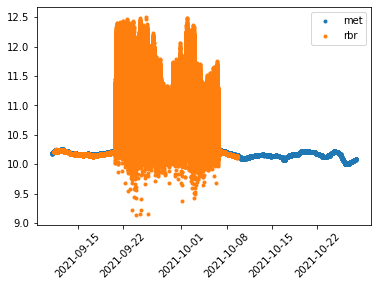

In [5]:
# Plot the whole deployment, met station and RBR pressure sensor
plt.plot(met.time,met.BP,'.',label='met')
plt.plot(rbr.time,rbr.P_1,'.',label='rbr')

plt.xticks(rotation=45)
plt.legend()
plt.show()

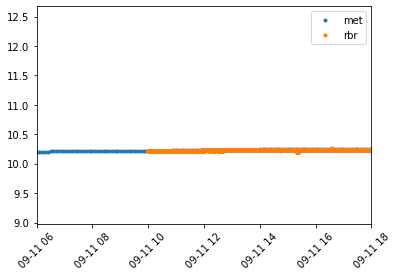

In [6]:
# Zoom into the pre-deployment portion, to get clean comparison

import datetime
# deployed 2021-09-11 17:37

dstart = datetime.datetime(2021,9,11, 6,0,0) # adjust as needed
dend = datetime.datetime(2021,9,11, 18,0,0)

plt.plot(met.time,met.BP,'.',label='met')
plt.plot(rbr.time,rbr.P_1,'.',label='rbr')

plt.xlim([dstart, dend])
# plt.ylim([10.2, 10.24]) # adjust as needed
plt.xticks(rotation=45)
plt.legend()
plt.show()

Select times within the pre-deployment timeframe (as seen in the figure above)

In [7]:
# indices of 3 points (to compare press value)
imet = met.sel(time = slice('2021-09-11 11:00:00', '2021-09-11 11:12:00'))
imet

<xarray.Dataset>
Dimensions:  (time: 3)
Coordinates:
  * time     (time) datetime64[ns] 2021-09-11T11:00:00 ... 2021-09-11T11:12:00
Data variables:
    Baro     (time) float64 1.022e+03 1.023e+03 1.023e+03
    BP       (time) float64 10.22 10.23 10.23

In [8]:
# indices of same 3 points (to compare press value)
irbr = rbr.sel(time = imet.time, method='nearest')
irbr

<xarray.Dataset>
Dimensions:  (time: 3, sample: 1, lat: 1, lon: 1)
Coordinates:
  * time     (time) datetime64[ns] 2021-09-11T11:00:00 ... 2021-09-11T11:12:00
  * sample   (sample) int32 0
  * lat      (lat) float64 35.68
  * lon      (lon) float64 -75.48
Data variables:
    P_1      (time, sample) float64 10.22 10.22 10.22
    burst    (time) int32 ...
Attributes: (12/40)
    SciPi:                           C. Sherwood
    PROJECT:                         USGS Coastal and Marine Geology Program
    EXPERIMENT:                      DUNEX
    DESCRIPTION:                     Cape Hatteras National Seashore, Pea Isl...
    DATA_SUBTYPE:                    POLE-MOUNTED
    DATA_ORIGIN:                     USGS WHCMSC Coastal and Estuarine Dynami...
    ...                              ...
    sample_interval:                 0.125
    samples_per_burst:               1
    burst_interval:                  0.125
    burst_length:                    0.125
    serial_number:                   208010
    INST_TYPE:                       RBR Virtuoso d|wave

In [9]:
# median diff between met and rbr
bpoffset = (irbr.P_1 - imet.BP).median()
bpoffset

<xarray.DataArray ()>
array(-0.00933933)

### Generate the atmpres.cdf file 
This generates the file and embeds the instrument-specific offset as an attr. The trickiest part of this process is determining what to use as an offset (Use matlab gui for help). After you run this cell, you will have your very own atmpres.cdf file!

In [3]:
# Load the raw rbr data (under new name)
RAW = xr.open_dataset(basedir + '1140solo3d-raw.cdf') 

# Load the met data (under new name)
gndcrmet = xr.open_dataset(metdir + 'OregonIn_filled_met.nc')

met = gndcrmet['BP'] # make a new met variable
met = met.rename('atmpres') # rename it to the standard atmpres variable name
met = met.reindex(time=RAW['time'], copy=True, method='nearest') # reindex the met data onto the Aquadopp time base
met.attrs.update(offset= -0.00933933) # set the atmospheric offset as an attribute

In [4]:
# determine what to put in "encoding"
met.time[0]

<xarray.DataArray 'time' ()>
array('2021-09-11T10:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2021-09-11T10:00:00

In [3]:
# make sure 'nanoseconds since XXX' time is correct
met.to_netcdf(basedir + 'atmpres1140.cdf', encoding={'time':{'units':'nanoseconds since 2021-09-11 10:00:00'}}) # save to disk

NameError: name 'met' is not defined

In [16]:
met

<xarray.DataArray 'atmpres' (time: 27882665)>
[27882665 values with dtype=float64]
Coordinates:
  * time     (time) datetime64[ns] 2021-09-11T10:00:00 ... 2021-10-22T00:02:0...
Attributes:
    offset:   -0.01069061

In [17]:
RAW

<xarray.Dataset>
Dimensions:  (time: 27882665, sample: 1, lat: 1, lon: 1)
Coordinates:
  * time     (time) datetime64[ns] 2021-09-11T10:00:00 ... 2021-10-22T00:02:0...
  * sample   (sample) int32 0
  * lat      (lat) float64 35.68
  * lon      (lon) float64 -75.48
Data variables:
    P_1      (time, sample) float64 ...
    burst    (time) int32 ...
Attributes: (12/40)
    SciPi:                           C. Sherwood
    PROJECT:                         USGS Coastal and Marine Geology Program
    EXPERIMENT:                      DUNEX
    DESCRIPTION:                     Cape Hatteras National Seashore, Pea Isl...
    DATA_SUBTYPE:                    POLE-MOUNTED
    DATA_ORIGIN:                     USGS WHCMSC Coastal and Estuarine Dynami...
    ...                              ...
    sample_interval:                 0.125
    samples_per_burst:               1
    burst_interval:                  0.125
    burst_length:                    0.125
    serial_number:                   208009
    INST_TYPE:                       RBR Virtuoso d|wave

### Create clipped and atmospherically corrected .nc file using raw file and atmpres file

In [4]:
run C:\Users\nrrandall\git\stglib\scripts\runrskcdf2nc.py --atmpres C:\Users\nrrandall\NRR\DUNEX\1140\rbr208010\atmpres1140.cdf C:\Users\nrrandall\NRR\DUNEX\1140\rbr208010\1140solo3d-raw.cdf

first burst in full file: 2021-09-11T10:00:00.000000000, idx 0
last burst in full file: 2021-10-09T14:37:56.375000064, idx 19487011
Clipping data using Deployment_date and Recovery_date
first burst in trimmed file: 2021-09-20T16:43:00.000000000
last burst in trimmed file: 2021-10-06T17:20:59.875000064
Atmospherically correcting data
Correcting using offset of -0.009339
Creating depth dimension
Writing cleaned/trimmed data to .nc file
not renaming 2D time because CF==1.6
Done writing netCDF file 1140solo3db-cal.nc


In [5]:
nc = netCDF4.Dataset(basedir + '1140solo3db-cal.nc')
nc

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    SciPi: C. Sherwood
    PROJECT: USGS Coastal and Marine Geology Program
    EXPERIMENT: DUNEX
    DESCRIPTION: Cape Hatteras National Seashore, Pea Island, NC
    DATA_SUBTYPE: POLE-MOUNTED
    DATA_ORIGIN: USGS WHCMSC Coastal and Estuarine Dynamics Group
    COORD_SYSTEM: GEOGRAPHIC + sample
    Conventions: CF-1.6
    MOORING: 1140
    WATER_DEPTH: 0.0
    WATER_DEPTH_NOTE: (meters), nominal depth
    latitude: 35.677574
    longitude: -75.47939
    magnetic_variation: -11.03
    Deployment_date: 2021-09-20 16:43
    Recovery_date: 2021-10-06 17:20
    DATA_CMNT: Magnetic declination determined using https://www.ngdc.noaa.gov/geomag/declination.shtml IGRF model
    platform_type: POLE
    DRIFTER: 0.0
    POS_CONST: 0.0
    DEPTH_CONST: 0.0
    WATER_MASS: Atlantic Ocean, Pea Island, NC
    VAR_FILL: 1e+35
    institution: United States Geological Survey, Woods Hole Coastal and Marine Science Ce

Plot data to make sure correction worked

Text(0, 0.5, 'Pressure (dbar)')

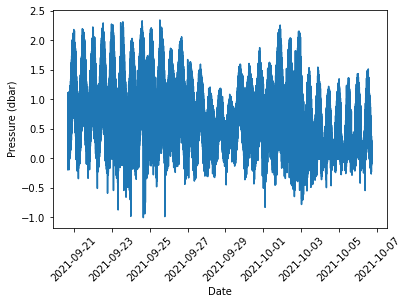

In [6]:
cal = xr.open_dataset(basedir + '1140solo3db-cal.nc')

plt.plot(cal.time,cal.P_1ac)
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Pressure (dbar)')